# Homework 7 *\[submission template\]*

In [3]:
from dataclasses import dataclass
import enum

import numpy as np
import matplotlib.pyplot as plt

In [4]:
RNG = np.random.default_rng()
# your additional global initialization here

## §1. Implementing generic Markov chain simulations

#### CODE: `Model` interface

In [5]:
class Model:

    def transition_rate(self, state):
        """Total transition rate out of the given state"""
        raise NotImplementedError

    def sample_next(self, state):
        """Generates a random state to come after the given state"""
        raise NotImplementedError

#### CODE: simulating *discrete-time* Markov chains

In [6]:
def run_dtmc(model: Model, state_init, n_steps=256):
    path = [state_init]
    for i in range(n_steps):
        path.append(model.sample_next(path[-1]))
    # Return a list of (time, state) pairs
    # This simulation is discrete-time, so time is an integer
    return list(enumerate(path))

#### CODE: `QueueModel` example

In [7]:
@dataclass
class QueueModel(Model):
    """Model of a queue

    The state is the number of customers currently in the queue.

    Parameters
    ----------
    rate_arrival: float
        Rate at which customers arrive at the queue.

    rate_service: float
        Rate at which customers leave the queue when it is nonempty.
    """

    rate_arrival: float
    rate_service: float

    def transition_rate(self, state: int):
        if state == 0:
            return self.rate_arrival
        else:
            return self.rate_arrival + self.rate_service

    def sample_next(self, state: int):
        if RNG.random() < self.rate_arrival / self.transition_rate(state):
            return state + 1
        else:
            return state - 1

In [ ]:
def visualize_queue_path(path):
    plt.plot(*np.asarray(path).T)

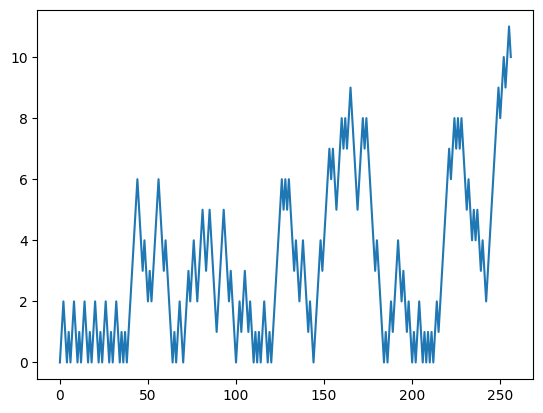

In [ ]:
visualize_queue_path(run_dtmc(QueueModel(5, 6), 0))

#### ANSWER

In [8]:
def run_ctmc(model: Model, state_init: int, n_steps: int = 256):
    """
    Simulates a continuous-time Markov chain (CTMC) for a given model.

    Parameters
    ----------
        model (Model):
            The Markov chain model, with `transition_rate` and `sample_next` methods.

        state_init (int):
            The initial state of the chain.

        n_steps (int):
            The number of steps to simulate.

    Returns:
        List[Tuple[float, int]]: A list of (time, state) pairs representing the path.
    """
    paths = [(0, state_init)] # Time, State

    for _ in range(n_steps):
        current_time, current_state = paths[-1]
        rate = model.transition_rate(current_state)

        time_step = RNG.exponential(1 / rate)
        new_state = model.sample_next(current_state)

        # To handle edge case where rate is 0
        if (type(time_step) not in [int,float]):
            time_step[np.isinf(time_step)] = 0

        new_path = (current_time + time_step, new_state)
        paths.append(new_path)

    return paths


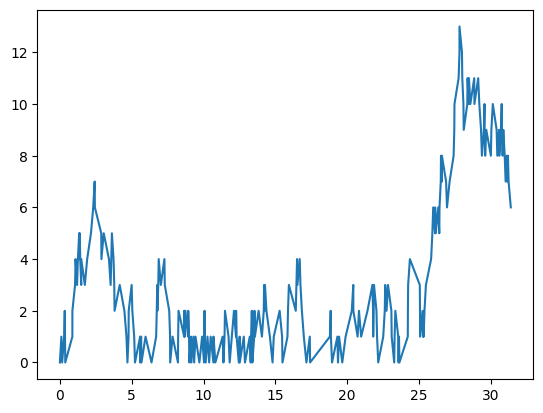

In [ ]:
# An initial test
visualize_queue_path(run_ctmc(QueueModel(5, 6), 0))

## §2. Implementing initial model for the project

#### ANSWER

In [9]:
# Changed to be list of femalees for easier acceess and generalization
@dataclass(frozen=True)
class SimpleWorkplaceState:
    n_females:list

# Changed levels to be a list and added rate matrix and weight matrix
@dataclass(frozen=True)
class WorkplaceParams:
    n_levels:list
    rate_matrix:np.matrix
    weight_matrix:np.matrix

@dataclass(frozen=True)
class SimpleWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState):
        return self.params.rate_matrix

    def adjust_rate(self, state: SimpleWorkplaceState):
        """Ensures that more employees don't leave than currenetly employeed"""
        rate = self.transition_rate(state).copy()
        for i in range(rate.shape[0]):
            for j in range(rate.shape[1]):
                if (i == 0): # Male
                    rate[i,j] = min(rate[i,j], self.params.n_levels[j] - state.n_females[j])
                else:
                    rate[i,j] = min(rate[i,j], state.n_females[j])
        return rate

    def sample_next(self, state: SimpleWorkplaceState):
        rate = self.adjust_rate(state)
        weights = self.params.weight_matrix

        employees_gone = np.sum(rate, axis=0)  # Total employees leaving per level
        new_females = []

        for i in range(len(employees_gone) - 1, -1, -1):
            if i == 0:
                # Hire New Employees
                new_hires = RNG.binomial(employees_gone[i], weights[1, i] / (weights[0, i] + weights[1, i]))
                new_females.append(new_hires)
            else:
                # Promote from last level
                f_prop = weights[0, i] * state.n_females[i - 1]
                m_prop = weights[1, i] * (self.params.n_levels[i - 1] - state.n_females[i - 1])
                new_hires = RNG.binomial(employees_gone[i], f_prop / (f_prop + m_prop))

                # employees_gone[i - 1] += new_hires
                # state.n_females[i - 1] -= new_hires
                new_females.append(new_hires)

        # Reverse new_females to align with asceending level ordering
        new_females = np.array(new_females[::-1])

        # Limit the new female employees to be in [0,n_l]
        new_n_females = np.clip(state.n_females + new_females - rate[1, :], 0, self.params.n_levels)
        return SimpleWorkplaceState(list(new_n_females))


In [10]:
initial_state = SimpleWorkplaceState([100, 50, 10, 3])
initial_workplace = WorkplaceParams([200, 100, 20, 5], np.ones((2,4)), np.ones((2,4))) # Simple rates and weights
results = run_ctmc(SimpleWorkplaceModel(initial_workplace), initial_state, 1000)

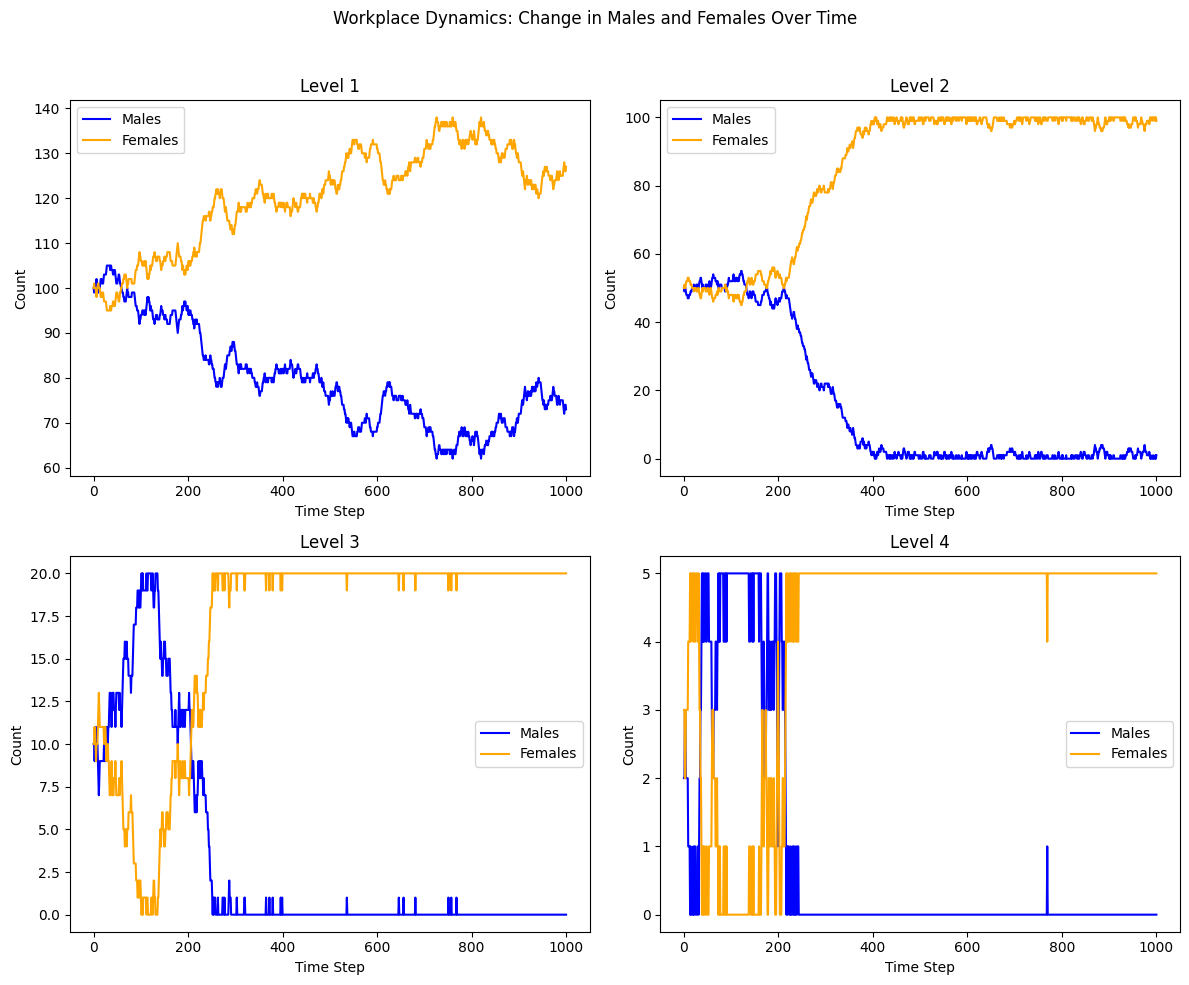

In [11]:
def plot_workplace_dynamics_line(data_list, level_sizes):
    """
    Plots the change in females and males over time for each level using a 2x2 subplot of line graphs.

    Args:
        data_list (list):
            A list of tuples, where:
            - data_list[i][0] is the array with people leaving at each level at a given time step.
            - data_list[i][1] is a SimpleWorkplaceState object with the number of females.
    """
    n_levels = 4
    time_steps = len(data_list)
    females_over_time = []
    males_over_time = []

    for (time, state) in data_list:
        females_over_time.append(state.n_females)
        males_over_time.append(level_sizes - females_over_time[-1])

    females_over_time = np.array(females_over_time)
    males_over_time = np.array(males_over_time)

    # Create 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Workplace Dynamics: Change in Males and Females Over Time")

    for level in range(n_levels):
        row, col = divmod(level, 2)
        ax = axes[row, col]

        # Plot line graphs for males and females over time
        ax.plot(range(time_steps), males_over_time[:, level], label="Males", linestyle="-", color="blue")
        ax.plot(range(time_steps), females_over_time[:, level], label="Females", linestyle="-", color="orange")
        ax.set_title(f"Level {level + 1}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_workplace_dynamics_line(results, np.array(initial_workplace.n_levels))


## §3. Implementing a more extensible model for the project

#### ANSWER

In [12]:
class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

@dataclass(frozen=True)
class Employee:
    identity: Identity
    hiring_and_promotion_times: tuple[float, ...]

    @property
    def level(self):
        return len(self.hiring_and_promotion_times) - 1

    @property
    def current_level_time(self):
        return self.hiring_and_promotion_times[-1]

    def promoted(self, t_now:float):
        return Employee(self.identity, (*self.hiring_and_promotion_times, t_now),)

    @staticmethod
    def sample_new_hire(p_female, t_now):
        i = Identity.FEMALE if RNG.random() < p_female else Identity.MALE
        return Employee(i, (t_now,))


@dataclass
class ComplexWorkplaceState:
    employees_0: tuple[Employee, ...]
    employees_1: tuple[Employee, ...]
    employees_2: tuple[Employee, ...]
    employees_3: tuple[Employee, ...]

    def to_simple_state(self):
        return SimpleWorkplaceState(
            sum(1 for e in self.employees_0 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_1 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_2 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_3 if e.identity == Identity.FEMALE),
        )

    @property
    def n_females(self):
        return self.to_simple_state().n_females

@dataclass
class ComplexWorkplaceModel:
    req_seniority: tuple[float, ...]
    params: WorkplaceParams

    def transition_rate(self, state: ComplexWorkplaceState):
        return self.params.rate_matrix

    def adjust_rate(self, state: ComplexWorkplaceState):
        """Ensures that more employees don't leave than currenetly employeed"""
        rate = self.transition_rate(state).copy()
        for i in range(rate.shape[0]):
            for j in range(rate.shape[1]):
                if (i == 0): # Male
                    rate[i,j] = min(rate[i,j], self.params.n_levels[j] - state.n_females[j])
                else:
                    rate[i,j] = min(rate[i,j], state.n_females[j])
        return rate

    def helper(self, state: ComplexWorkplaceState):
        new_employees_0 = []
        new_employees_1 = []
        new_employees_2 = []
        new_employees_3 = []

        for emp in state.employees_0:
            if emp.current_level_time >= self.req_seniority[0]:
                new_employees_1.append(emp.promoted(RNG.random()))
            else:
                new_employees_0.append(emp)

        for emp in state.employees_1:
            if emp.current_level_time >= self.req_seniority[1]:
                new_employees_2.append(emp.promoted(RNG.random()))
            else:
                new_employees_1.append(emp)

        for emp in state.employees_2:
            if emp.current_level_time >= self.req_seniority[2]:
                new_employees_3.append(emp.promoted(RNG.random()))
            else:
                new_employees_2.append(emp)

        for emp in state.employees_3:
            new_employees_3.append(emp)

        return ComplexWorkplaceState(
            tuple(new_employees_0),
            tuple(new_employees_1),
            tuple(new_employees_2),
            tuple(new_employees_3)
        )

    def sample_next(self, state: ComplexWorkplaceState):
        return self.helper(state)

In [13]:
complex_initial_state = ComplexWorkplaceState(
    (Employee.sample_new_hire(0.5, 42) for i in range(200)),
    (Employee.sample_new_hire(0.5, 42) for i in range(100)),
    (Employee.sample_new_hire(0.5, 42) for i in range(20)),
    (Employee.sample_new_hire(0.5, 42) for i in range(5)),
)
initial_levels = [200, 100, 20, 5]
intitial_rate_matrix = np.ones((2,4))
initial_weights = np.ones((2,4))
required_seniority = (1, 2, 3, 4)

In [14]:
complex_initial_workplace = WorkplaceParams(initial_levels, intitial_rate_matrix, initial_weights)
complex_results = run_ctmc(ComplexWorkplaceModel(required_seniority, complex_initial_workplace), complex_initial_state, 1000)

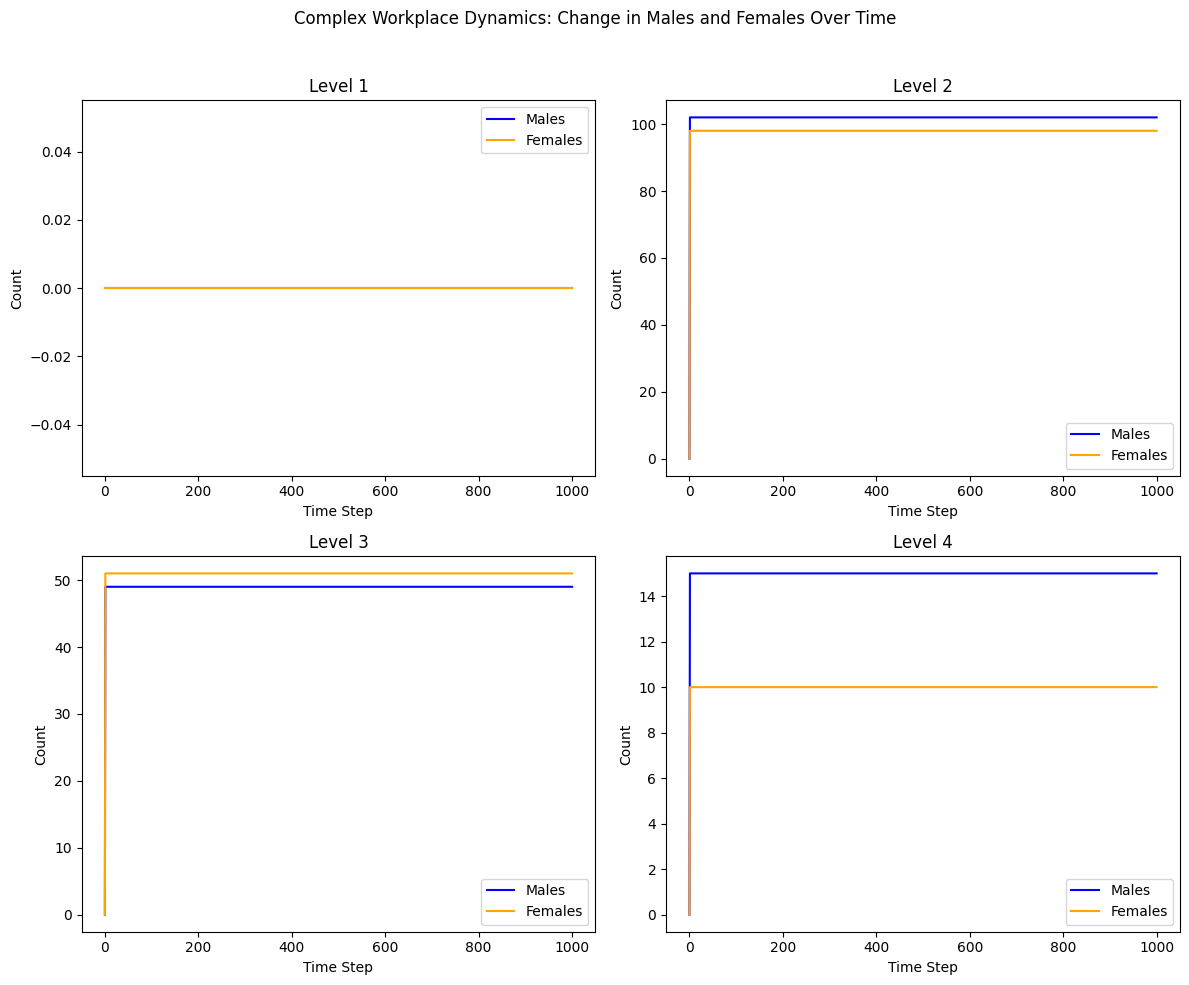

In [ ]:
def plot_complex_workplace_dynamics_line(data_list, level_sizes):
      """
      Plots the change in females and males over time for each level using a 2x2 subplot of line graphs.

      Args:
            data_list (list):
                  A list of tuples, where:
                  - data_list[i][0] is the time step.
                  - data_list[i][1] is a ComplexWorkplaceState object with the employees at each level.
      """
      n_levels = 4
      time_steps = len(data_list)
      females_over_time = []
      males_over_time = []

      for (time, state) in data_list:
            females_over_time.append([
                  sum(1 for e in state.employees_0 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_1 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_2 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_3 if e.identity == Identity.FEMALE),
            ])
            males_over_time.append([
                  sum(1 for e in state.employees_0 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_1 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_2 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_3 if e.identity == Identity.MALE),
            ])

      females_over_time = np.array(females_over_time)
      males_over_time = np.array(males_over_time)

      # Create 2x2 subplots
      fig, axes = plt.subplots(2, 2, figsize=(12, 10))
      fig.suptitle("Complex Workplace Dynamics: Change in Males and Females Over Time")

      for level in range(n_levels):
            row, col = divmod(level, 2)
            ax = axes[row, col]

            # Plot line graphs for males and females over time
            ax.plot(range(time_steps), males_over_time[:, level], label="Males", linestyle="-", color="blue")
            ax.plot(range(time_steps), females_over_time[:, level], label="Females", linestyle="-", color="orange")
            ax.set_title(f"Level {level + 1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Count")
            ax.legend()

      plt.tight_layout(rect=[0, 0, 1, 0.96])
      plt.show()

plot_complex_workplace_dynamics_line(complex_results, np.array(complex_initial_workplace.n_levels))

Seniority: is seniority a neutral factor, or does it just amplify existing biases?

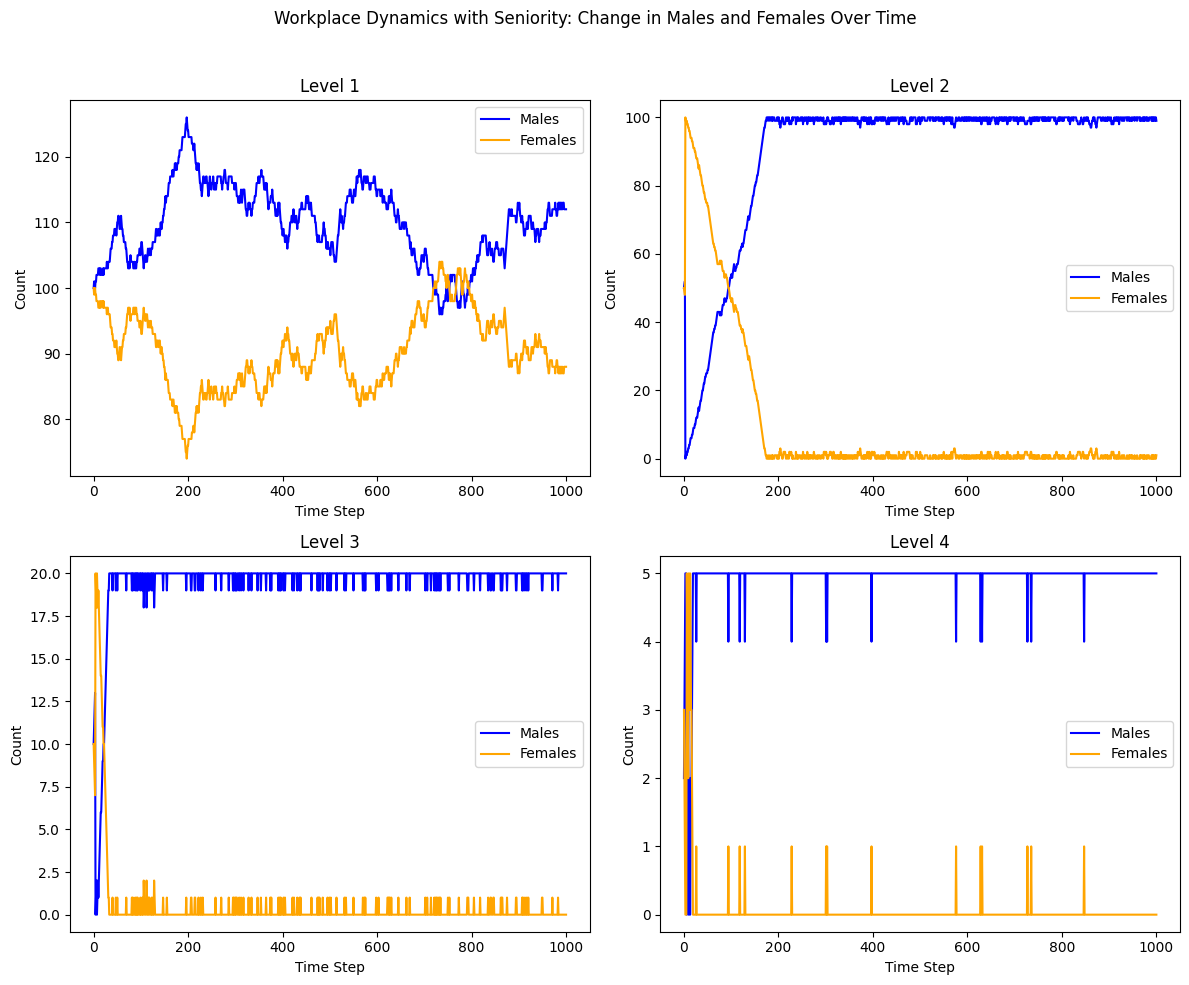

In [25]:
# Required imports
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import enum

# Random number generator
RNG = np.random.default_rng()

# Define identities for employees
class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

# Define SimpleWorkplaceState with seniority
@dataclass(frozen=True)
class SimpleWorkplaceStateWithSeniority:
    n_females: list  # Number of females at each level
    seniority: list  # List of arrays tracking time at the current level for each individual

# Workplace parameters with seniority
@dataclass(frozen=True)
class WorkplaceParamsWithSeniority:
    n_levels: list  # Total positions at each level
    rate_matrix: np.matrix  # Transition rates
    weight_matrix: np.matrix  # Gender-based weights
    seniority_requirements: list  # Seniority requirements for promotion

# Workplace model with seniority
@dataclass(frozen=True)
class SimpleWorkplaceModelWithSeniority:
    params: WorkplaceParamsWithSeniority

    def transition_rate(self, state: SimpleWorkplaceStateWithSeniority):
        return self.params.rate_matrix

    def adjust_rate(self, state: SimpleWorkplaceStateWithSeniority):
        """Ensures no more employees leave than currently employed."""
        rate = self.transition_rate(state).copy()
        for i in range(rate.shape[0]):
            for j in range(rate.shape[1]):
                if i == 0:  # Male departures
                    rate[i, j] = min(rate[i, j], self.params.n_levels[j] - state.n_females[j])
                else:  # Female departures
                    rate[i, j] = min(rate[i, j], state.n_females[j])
        return rate

    def sample_next(self, state: SimpleWorkplaceStateWithSeniority):
        """Handles promotions and seniority-based transitions."""
        rate = self.adjust_rate(state)
        weights = self.params.weight_matrix

        employees_gone = np.sum(rate, axis=0)  # Total employees leaving per level
        new_females = []
        new_seniority = [[] for _ in range(len(self.params.n_levels))]

        for i in range(len(employees_gone) - 1, -1, -1):
            if i == 0:
                # Hire new employees
                new_hires = RNG.binomial(employees_gone[i], weights[1, i] / (weights[0, i] + weights[1, i]))
                new_females.append(new_hires)
                new_seniority[i].extend([0] * new_hires)
            else:
                # Promote based on seniority requirements
                promotable_females = [
                    t >= self.params.seniority_requirements[i - 1]
                    for t in state.seniority[i - 1]
                ]
                # Convert state.n_females[i - 1] to int for slicing
                f_count = int(state.n_females[i - 1])
                f_promotions = np.sum(promotable_females[:f_count])
                m_promotions = employees_gone[i] - f_promotions

                new_hires = RNG.binomial(f_promotions, weights[0, i] / (weights[0, i] + weights[1, i]))
                new_females.append(new_hires)
                new_seniority[i].extend([0] * new_hires)

                # Update seniority for remaining employees
                new_seniority[i - 1] = [
                    t + 1 for t, promotable in zip(state.seniority[i - 1], promotable_females) if not promotable
                ]

        # Reverse new_females to align with ascending level ordering
        new_females = np.array(new_females[::-1])

        # Limit the new female employees to be in [0, n_levels]
        new_n_females = np.clip(state.n_females + new_females - rate[1, :], 0, self.params.n_levels)
        return SimpleWorkplaceStateWithSeniority(list(new_n_females), new_seniority)

# Initial state with seniority tracking
initial_seniority = [[0] * 100, [0] * 50, [0] * 10, [0] * 3]
initial_state_with_seniority = SimpleWorkplaceStateWithSeniority([100, 50, 10, 3], initial_seniority)

# Workplace parameters with seniority requirements
initial_workplace_with_seniority = WorkplaceParamsWithSeniority(
    n_levels=[200, 100, 20, 5],  # Total positions
    rate_matrix=np.ones((2, 4)),  # Transition rates
    weight_matrix=np.ones((2, 4)),  # Gender-based weights
    seniority_requirements=[2, 3, 5, None]  # Seniority requirements for promotion
)

# Simulation function
def run_ctmc_with_seniority(model, state_init, n_steps):
    """Runs the workplace simulation."""
    path = [(0, state_init)]
    for t in range(1, n_steps + 1):
        next_state = model.sample_next(path[-1][1])
        path.append((t, next_state))
    return path

# Simulate dynamics
results_with_seniority = run_ctmc_with_seniority(
    SimpleWorkplaceModelWithSeniority(initial_workplace_with_seniority),
    initial_state_with_seniority,
    1000
)

# Plotting function
def plot_workplace_dynamics_line_with_seniority(data_list, level_sizes):
    """Plots gender representation over time with seniority."""
    n_levels = len(level_sizes)
    time_steps = len(data_list)
    females_over_time = []
    males_over_time = []

    for (_, state) in data_list:
        females_over_time.append(state.n_females)
        males_over_time.append(level_sizes - np.array(state.n_females))

    females_over_time = np.array(females_over_time)
    males_over_time = np.array(males_over_time)

    # Create 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Workplace Dynamics with Seniority: Change in Males and Females Over Time")

    for level in range(n_levels):
        row, col = divmod(level, 2)
        ax = axes[row, col]

        # Plot line graphs for males and females over time
        ax.plot(range(time_steps), males_over_time[:, level], label="Males", linestyle="-", color="blue")
        ax.plot(range(time_steps), females_over_time[:, level], label="Females", linestyle="-", color="orange")
        ax.set_title(f"Level {level + 1}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot the results
plot_workplace_dynamics_line_with_seniority(results_with_seniority, np.array(initial_workplace_with_seniority.n_levels))


### **Explanation of the First Image (Graphs with Strong Seniority Influence)**

1. **Level 1 (Top Left):**
   - Males and females fluctuate but remain competitive over time.
   - Seniority doesn’t play a strong role here because employees are hired directly, bypassing promotion processes.

2. **Level 2 (Top Right):**
   - Males quickly dominate while females decline steadily.
   - Seniority amplifies biases at this level by delaying female promotions, resulting in near-total male representation.

3. **Level 3 (Bottom Left):**
   - Males dominate after initial competition. Females decline to near-zero.
   - Seniority requirements further limit female promotions to this level, cementing male dominance.

4. **Level 4 (Bottom Right):**
   - Representation fluctuates due to low population but trends toward male dominance.
   - Seniority delays create bottlenecks, excluding females from reaching this level.

---

### **Comparison to Original Graphs without Seniority Influence (Q2)**

1. **Level 1:**
   - Both graphs show fluctuations but are more extreme without seniority.
   - Seniority dampens rapid fluctuations but doesn’t drastically change outcomes.

2. **Level 2:**
   - Without seniority, males and females compete, eventually achieving balance.
   - With seniority, male dominance emerges quickly, suppressing female representation.

3. **Level 3:**
   - Without seniority, females retain some presence.
   - With seniority, males dominate earlier and more completely, excluding females.

4. **Level 4:**
   - Both graphs show fluctuations, but seniority amplifies male representation over time.

---

### **Answer to the Question: Is Seniority a Neutral Factor?**

Seniority is **not a neutral factor**. It amplifies existing biases by creating **delays in promotions** that disproportionately impact underrepresented groups (females). Over time, seniority reinforces male dominance at higher levels, reducing female representation and widening gender disparities.